# Classifying Legendary Pokemon

Our love for pokemon as children is no secret. As we grow up we turn to other hobbies but the memories of that time always remain.

I'll be using this series as inspiration for this project, where, using the pokedex data, with all pokemons' stats, i'll try to predict which ones of them are legendary or not.

Hope you'll enjoy!!

# Importing Libraries

First of all, let's import some libraries.

In [21]:
##Importing Libraries

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pandasql import sqldf

from sklearn.model_selection import train_test_split
import category_encoders as ce

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

import torch
from torch import nn

# Importing Main Dataset

Now let's get the ata we'll use in this analysis.

In [22]:
##Here I'll import my main dataset

pokemon_db =  pd.read_csv('Pokemon.csv',encoding='utf-8', sep=',', header=0)

display(pokemon_db.head())

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


# NOW I'LL MAKE SOME EXPLORATORY ANALYSIS INTO THE DATA

### 1. DISCOVERING THE MOST PREDOMINANT POKEMON TYPES

Here we can see the most common types of Pokemon in all the regions. The most common type is Water followed by Normal .



,Type 1,Count
0,Water,112
1,Normal,98
2,Grass,70
3,Bug,69
4,Psychic,57
5,Fire,52
6,Rock,44
7,Electric,44
8,Ground,32
9,Ghost,32


Now lets make some viz so we can better visualize this data. Ill use a pie chart here.


Text(0.5, 1.0, 'Pokemon Type Distribution [%]')

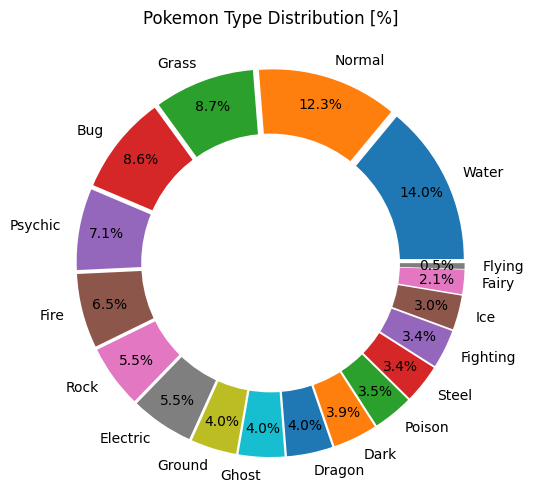

In [23]:
##Let's see the pokemon's most common types



pokemon_types_db = sqldf('''

SELECT pokemon_db.'Type 1', COUNT(pokemon_db.'Type 1') as Count

                    FROM pokemon_db

        GROUP BY pokemon_db.'Type 1'
        
        ORDER BY COUNT(pokemon_db.'Type 1') DESC

''')


print('Here we can see the most common types of Pokemon in all the regions. The most common type is',pokemon_types_db['Type 1'][0],'followed by',pokemon_types_db['Type 1'][1],'.\n')
display(pokemon_types_db)



fig, ax = plt.subplots(1,1,figsize=(6,6))


print('Now let''s make some viz so we can better visualize this data. I''ll use a pie chart here.')


##Now We'll make some graphics in order to get a better visualization of the data

##creates explode array 

my_explode = [0.05]*len(pokemon_types_db['Count'])


##creates pie chart
ax.pie(pokemon_types_db['Count'],  labels=pokemon_types_db['Type 1'],autopct='%1.1f%%', pctdistance=0.85,  explode=my_explode)
 
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig1 = plt.gcf()
 
# Adding Circle in Pie chart
fig1.gca().add_artist(centre_circle)
 
# Adding Title of chart
ax.set_title('Pokemon Type Distribution [%]')

### 2.IDENTIFYING DISPERSION OF POKEMON PER TOTAL AND HP


Here Ill just make a subquery so I can replace the 0s and 1s in the Legendary Collumn by Legendary and Non-Legendary.

Here we are able to see that legendary pokemon have a tendency to have higher total stats and attack attributes. We also have to be careful, because there some normal pokemon that figure among the legendary in terms of stats levels.


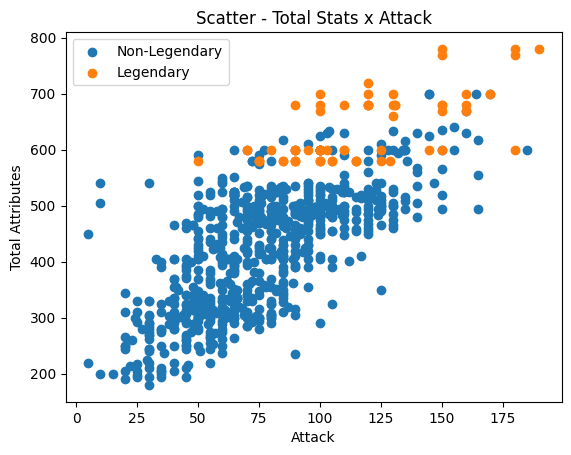

In [24]:
##Here I''ll just make a subquery so I can replace the 0s and 1s in the Legendary Collumn by Legendary and Non-Legendary
print('\nHere I''ll just make a subquery so I can replace the 0s and 1s in the Legendary Collumn by Legendary and Non-Legendary.')

pokemon_new_legend_db = sqldf('''

SELECT *, CASE WHEN Legendary in (0) then 'Blue' else 'Orange'  end as 'Legendary Color'

                            From pokemon_db 


''')


print('\nHere we are able to see that legendary pokemon have a tendency to have higher total stats and attack attributes. We also have to be careful, because there some normal pokemon that figure among the legendary in terms of stats levels.')


##Now we'll plot this info into a scatterplot so we can better understand it

fig, ax = plt.subplots()

ax.scatter( pokemon_new_legend_db.query('Legendary==0')['Attack'],pokemon_new_legend_db.query('Legendary==0')['Total'])
ax.scatter( pokemon_new_legend_db.query('Legendary==1')['Attack'],pokemon_new_legend_db.query('Legendary==1')['Total'])
ax.legend(["Non-Legendary" , "Legendary"])
ax.set_ylabel('Total Attributes')
ax.set_xlabel('Attack')
ax.set_title('Scatter - Total Stats x Attack')

plt.show()

# Neural Network Building

Now we'll start building our neural network.

## 1. Split Dataset
Let's split our dataset into train and test data.

In [25]:
##Separating my analysis variables
##We'll use as independent variables all columns except the one we want to estimate with our decision tree.

X = pokemon_db.drop(['Legendary','Name','#','Generation','Speed','Defense','Sp. Atk','Sp. Def','Type 1','Type 2'], axis=1)
y = pokemon_db['Legendary']

In [26]:
##Creating train and test selections

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

display(X_train)

,Total,HP,Attack
239,450,100,100
88,325,25,35
674,305,55,70
172,314,50,65
84,500,65,100
...,...,...,...
461,424,70,94
56,405,35,80
759,500,72,105
721,307,40,45


## 2. Encoding Data

In order for our model to work, we'll need to encode all non-numerical variables.

In [27]:
encoder = ce.OrdinalEncoder(cols=['Type 1','Type 2'])##, 'Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed'])
##X_train = encoder.fit_transform(X_train)
##X_test = encoder.transform(X_test)

encoder2 = ce.OrdinalEncoder(cols=['Legendary'])
y_train = encoder2.fit_transform(y_train)
y_test = encoder2.fit_transform(y_test)


##Since the encoding stars at 1 and not zero (as the list index) we'll need to subtract 1 from 1 in order for these values to match.
y_train['Legendary'] = y_train['Legendary']  -1
y_test['Legendary'] = y_test['Legendary']  -1

##display(max(y_train['Legendary']))

##display(y_test)

## 3. Create Tensors

Now that we have our sets, we need to convert them to the format of pytorch tensors, so the library can use them

In [28]:
# 2. Turn data into tensors


X_train = torch.tensor(X_train.values).type(torch.float)
y_train = torch.tensor(y_train.values).type(torch.float)

X_test = torch.tensor(X_test.values).type(torch.float)
y_test = torch.tensor(y_test.values).type(torch.float)

Here i'll just define the part of the computer that will process the neural network.

In [29]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 4. Building Our Model

Now we'll build our neural network model.

Since the pytorch is a very flexible library, we'll create a class with all the modules we need into our network.

In [30]:
# Build model
class pkmodel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
            (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), #3 <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of model and send it to the target device
model_4 = pkmodel(input_features=3, ##Number of columns in input df
                    output_features=2, ##Number of classification options
                    hidden_units=2).to(device)
model_4

pkmodel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=3, out_features=2, bias=True)
    (1): ReLU()
  )
)

## 5. Creating Loss and Optmizer function

Here we'll define the main metrics used in order to train our model, the loss function and the optmizer.

In [31]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.000010) # exercise: try changing the learning rate here and seeing what happens to the model's performance

                            ##if logits return nan, try to lower the lr

## 6. Test our Model

Let's make 1 prediction in order to test our model functionality.

In [32]:
# Make prediction logits with model
y_logits = model_4(X_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[  0.0000, 141.4772],
        [  0.0000, 112.7007],
        [  0.0000, 152.9398],
        [  0.0000, 181.4287],
        [  0.0000, 176.7766]], grad_fn=<SliceBackward0>)
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], grad_fn=<SliceBackward0>)


In [33]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
##get's index of the highest value in each row
print('Most likely prediction:',torch.argmax(y_pred_probs[0]))

tensor([0., 1.], grad_fn=<SelectBackward0>)
Most likely prediction: tensor(1)


Now I'll create a accuracy function in order to take some metrics about our network's performance.

In [34]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [35]:
##Removing undesirable dimensions from y tensors
display(X_train.size())
y_train = torch.squeeze(y_train)
display(y_train.size())
display(X_test.size())
y_test = torch.squeeze(y_test)
display(y_test.size())

display(y_logits.size())

torch.Size([720, 3])

torch.Size([720])

torch.Size([80, 3])

torch.Size([80])

torch.Size([80, 2])

## 7. Train our Model

Here we'll train our model and compute the accuracy and loss for train and test datasets across the epochs.

In [36]:

# Set number of epochs
epochs = 500

##Generations before each results print
gen_print = 25

##set arrays for accuracy and loss

train_loss_time = []
train_acc_time = []

test_loss_time = []
test_acc_time = []

Generation = []

cont = 0

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

    cont = cont +1

    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    ##print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train.long())
    acc = accuracy_fn(y_true=y_train,
                        y_pred=y_pred)
    

    


    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()

    

    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_4(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_test.long())
        test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)
        
        ##Getting Loss for viz
        loss_train = loss_fn(y_logits, y_train.long())
        

        

    # Print out what's happening and gather data for viz
    if epoch % gen_print == 0:
        ##append epoch 
        Generation.append(epoch)
        test_loss_time.append(test_loss)
        test_acc_time.append(test_acc)
        train_loss_time.append(loss_train)
        train_acc_time.append(acc)

        ##print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

## 8. Analyse the Model Performance

Ok, let's look at some metrics of our model now.

First of all, let's print our accuracy an loss per epoch.

Here we can see that we have a big loss reduction throughout generations.

We also have a big accuracy improvement, which stays above 80%.

This indicates that our model is good at making the predictions



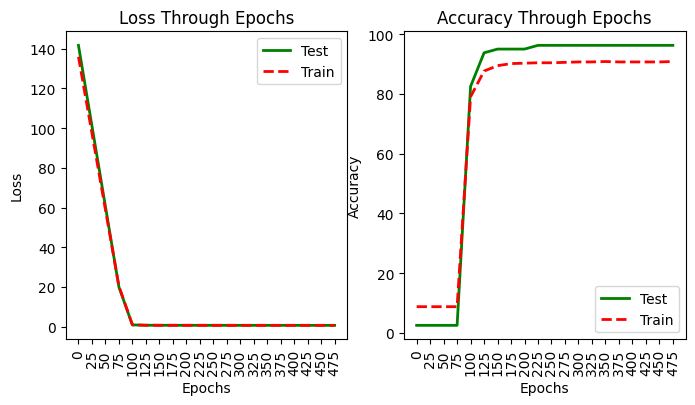

In [37]:
##Here We'll create and analyse the viz

print('Here we can see that we have a big loss reduction throughout generations.\n')
print('We also have a big accuracy improvement, which stays above 80%.\n')
print('This indicates that our model is good at making the predictions\n')


##Creating figure and plots

x = np.arange(len(Generation))

fig, ax = plt.subplots(1,2,figsize=(8,4))


ax[0].plot(test_loss_time,color='green',linewidth=2)
ax[0].plot(train_loss_time,color='red',linewidth=2,linestyle='--')
ax[0].set_xticks(x)
ax[0].set_xticklabels(Generation, rotation = 'vertical')
ax[0].set_title('Loss Through Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend(['Test','Train'])

ax[1].plot(test_acc_time,color='green', linewidth=2)
ax[1].plot(train_acc_time,color='red',linewidth=2,linestyle='--')

ax[1].set_xticks(x)
ax[1].set_xticklabels(Generation, rotation = 'vertical')
ax[1].set_title('Accuracy Through Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend(['Test','Train'])

plt.show()

I'd also like to generate a confuse matrix about our test set.

In [38]:
## Generating predictions on test set

with torch.inference_mode():
        
        logits = model_4(X_test)
        y_tot_pred = torch.softmax(logits, dim=1).argmax(dim=1)
        
##Plotting confusion matrix against true values

cm = confusion_matrix(y_test, y_tot_pred)

print('Confusion matrix:\n\n', cm)

print('\nHere we see that we have 74 true positives (main diagonal) against 6 false positives, which represents 92,5% of the predictions as being correct!!\n\nSo, it''s safe to say that we have a good model.')

Confusion matrix:

 [[77  1]
 [ 2  0]]

Here we see that we have 74 true positives (main diagonal) against 6 false positives, which represents 92,5% of the predictions as being correct!!

So, its safe to say that we have a good model.
